## C S 329E HW 9

# Clustering with DBSCAN

## Alex Chiu, Ella Jiang

As we discussed in lecture DBSCAN creates clusters based on the density of the points in the vicinity of the data.  Using small example data sets, we will implement both algorithms and visualize the results.

Even though the example data is small and 2 dimensional, write your helper functions to not assume a 2-D data set.  Your plotting code can reference the `x` and `y` column names from the sample data directly. 

Note that I have added a one or two lines of code to the questions to test your implementations. 

In [1]:
# Do not import anything else
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN # only on last problem

# DBSCAN

## Q1 Load the Density Data and try K-means

Load in the data provided `data_dbscan.csv`, cluster it with k-means algorithm with $k=2$ and visualize the results with a scatter plot, where the color indicates cluster membership. Label your axes, and give the plot a title. Use the [scikit-learn implementation of K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

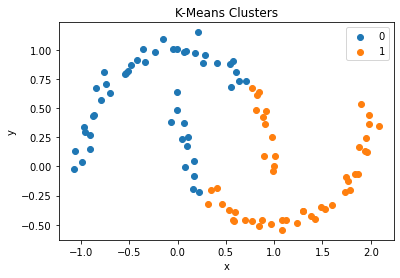

In [5]:
df_dbscan = pd.read_csv('data_dbscan.csv')

# Call k_means with k = 2
kmeans = KMeans(n_clusters=2)

# Run k-means algorithm
centroids = kmeans.fit_predict(df_dbscan)
df_dbscan["cluster"] = centroids

# Plot resulting clusters
k = len(np.unique(centroids))
for i in range(k):
    df_slice = df_dbscan.loc[df_dbscan["cluster"] == i]
    plt.scatter(df_slice.x, df_slice.y)
plt.legend(range(k))
plt.xlabel("x")
plt.ylabel("y")
plt.title("K-Means Clusters")
plt.show()

del df_dbscan["cluster"]



## Q2.2 Write function to Implement Range Query

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement RangeQuery.

```
RangeQuery(DB, distFunc, Q, eps) {
    Neighbors N := empty list
    for each point P in database DB {                      /* Scan all points in the database */
        if distFunc(Q, P) ≤ eps then {                     /* Compute distance and check epsilon */
            N := N ∪ {P}                                   /* Add to result */
        }
    }
    return N
}
```

The "DB" parameter is a data frame, `df_data` containing all of the points in our data set, the "distFunc" is set as Euclidean distance thus should not be passed in, the point "Q", is represented by the index of the data frame, `q_index`, where `df_data.iloc[q_index]` is the actual point, and `eps` is a floating point value that indicates the radius from the point "Q" to search for neighbors.  The function will return the slice of `df_data` of all points within `eps` distance of "Q" (including "Q").  The indices on the slice should be preserved (do not reset_index).  

In [3]:
# Range query function that returns a sliced data frame of nearby points
def range_query(df_data, q_index, eps):
    df_data["in_range"] = np.zeros((len(df_data), 1))
    
    # Loops through each other point in data set
    for i in range(len(df_data)):
        distance = dist(df_data.iloc[q_index].x, df_data.iloc[q_index].y, df_data.iloc[i].x, df_data.iloc[i].y)
        if (distance <= eps):
            df_data.at[i, "in_range"] = 1
    
    # Selects points that were within range
    df_slice = df_data.loc[df_data["in_range"] == 1]
    del df_data["in_range"]
    return df_slice

# Function that finds the distance between two points
def dist(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

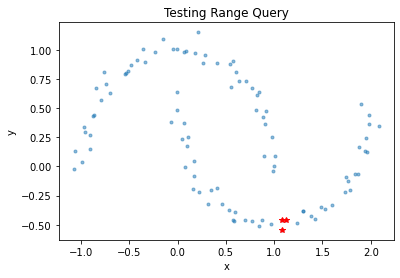

In [4]:
# Test it out
df_n = range_query(df_dbscan, 0, 0.1) 

# Plot the resulting range query test
plt.plot(df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5)
plt.plot(df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Q2.3 Write a function to implement DBSCAN

Using the [pseudo-code](https://en.wikipedia.org/wiki/DBSCAN#Algorithm) on wikipedia, implement DBSCAN. This algorithm uses set notation, I found a handy summary on-line [here](http://www.math.cmu.edu/~bkell/21110-2010s/sets.html) if you need a refresher. 

```
DBSCAN(DB, distFunc, eps, minPts) {
    C := 0                                                  /* Cluster counter */
    for each point P in database DB {
        if label(P) ≠ undefined then continue               /* Previously processed in inner loop */
        Neighbors N := RangeQuery(DB, distFunc, P, eps)     /* Find neighbors */
        if |N| < minPts then {                              /* Density check */
            label(P) := Noise                               /* Label as Noise */
            continue
        }
        C := C + 1                                          /* next cluster label */
        label(P) := C                                       /* Label initial point */
        SeedSet S := N \ {P}                                /* Neighbors to expand */
        for each point Q in S {                             /* Process every seed point Q */
            if label(Q) = Noise then label(Q) := C          /* Change Noise to border point */
            if label(Q) ≠ undefined then continue           /* Previously processed (e.g., border point) */
            label(Q) := C                                   /* Label neighbor */
            Neighbors N := RangeQuery(DB, distFunc, Q, eps) /* Find neighbors */
            if |N| ≥ minPts then {                          /* Density check (if Q is a core point) */
                S := S ∪ N                                  /* Add new neighbors to seed set */
            }
        }
    }
}
```

The function should accept as parameters "DB", a data frame of points to be clustered, `df_data`, no distance function (assuming Euclidean distance), a floating point `eps` that defines the radius, and an integer `minPts`.  The function will return a series of cluster assignments of the same length as `df_data`. If the data is classified as noise, the cluster assignment is $0$, and all of the clusters will have a label of $1-k$, were $k$ is derived in the function and represents the total number of clusters found. 

Don't forget that [iterrows](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html) is a lovely way to loop through a data frame. But if you modify the dataframe within the loop, it doesn't add more iterations to the loop.  For example, if you start with a dataframe of length $n$ and add $3$ rows, then the `iterrows` will stop after $n$ rows. For the inside loop, you'll need to use a native python list to dynamically grow the `SeedSet S`.  You can use the `extend` function to merge 2 lists together. For example:

```
x = [1,2,3]
y = [4,5,6]
x.extend(y) # sets x to the list [1, 2, 3, 4, 5, 6]
```

If you haven't used the [continue](https://docs.python.org/3/tutorial/controlflow.html) statement before, it can be useful in these situations, check out the link. 

Call `dbscan` with the `df_dbscan` data frame, `eps` set to 0.23, and `min_pts` set to 6 and save the results to `s_cluster_assignments` 

In [5]:
# Overall DBSCAN function
def dbscan(df_data, eps, min_pts):
    # Set initial point labels
    NOISE_LABEL = -1
    UNDEFINED = 0
    CLUSTER_CT = 0
    df_data["n"] = np.zeros((len(df_data), 1))
    
    # Loop through each point
    for i in range(len(df_data)):
        # If point is already labeled, continue
        if (df_data.iloc[i]["n"] != 0):
            continue
            
        # Find neighbors of current point
        neighbors = range_query(df_data, i, eps)
        
        # If not enough neighbors, label as noise point and continue
        if (len(neighbors) < min_pts):
            df_data.at[i, "n"] = -1
            continue
            
        # If enough neighbors, iterate cluster count and label point as part of cluster
        CLUSTER_CT += 1
        df_data.at[i, "n"] = CLUSTER_CT
        indices = neighbors.index.tolist()
        idx = 0
        
        # Continuously loop through neighbors
        while (idx < len(indices)):
            # If noise point, label as part of cluster now
            if (df_data.iloc[indices[idx]]["n"] == -1):
                df_data.at[indices[idx], "n"] = CLUSTER_CT
            # If not undefined, continue
            elif (df_data.iloc[indices[idx]]["n"] != 0):
                idx += 1
                continue
            # Otherwise, add to cluster and find new point's neighbors
            else:
                df_data.at[indices[idx], "n"] = CLUSTER_CT
                new_neighbors = range_query(df_data, indices[idx], eps)
                
                # If dense enough, add new neighbors to list of neighbors to search through
                if (len(new_neighbors) >= min_pts):
                    new_indices = new_neighbors.index.tolist()
                    indices.extend(new_indices)
            idx += 1
            
    return df_data

In [6]:
# Test it out
s_cluster_assignment = dbscan(df_dbscan, 0.23, 6)
s_cluster_assignment["n"].value_counts()

 1.0    49
 2.0    48
-1.0     3
Name: n, dtype: int64

## Q2.4 Plot the Results 

Plot the points in the `df_dbscan` data frame using a 2-D scatter plot, with a different color for each cluster.  Use the cluster assignments from the previous problem (`s_cluster_assignments`). Label your axes, and give the plot a title.

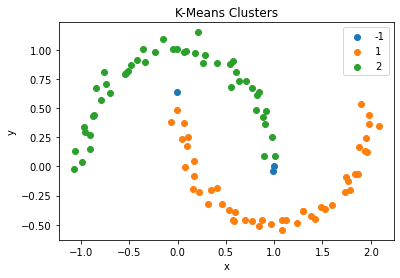

In [7]:
# Plot each cluster
vals = [-1]
k = len(np.unique(s_cluster_assignment["n"])) - 1
for i in range(k):
    vals.append(i + 1)

for i in range(len(vals)):
    df_slice = s_cluster_assignment.loc[s_cluster_assignment["n"] == vals[i]]
    plt.scatter(df_slice.x, df_slice.y)
    
plt.legend(vals)
plt.xlabel("x")
plt.ylabel("y")
plt.title("K-Means Clusters")
plt.show()

## Q2.5 Compare your results to the scikit-learn library

Import DBSCAN from scikit-learn and compare the cluster labels from your implementation to the cluster labels generated from [scikit-learn's DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Add some commentary about how you think the results compare. Use the same data and values for eps and minPts.

In [8]:
# check your implementation vs scikit-learn
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps=0.23, min_samples=6).fit(df_dbscan)
clusters.labels_

diff_vals = False

# Compare each point for both algorithms
for i in range(len(s_cluster_assignment)):
    # Rescale our labels to match those of sci-kit learn's DBSCAN
    if (s_cluster_assignment["n"].iloc[i] > 0):
        s_cluster_assignment["n"].iloc[i] -= 1
        
    # Compare cluster labels
    if (s_cluster_assignment["n"].iloc[i] != clusters.labels_[i]):
        print("Different cluster value at index " + str(i))
        diff_vals = True
        
if (diff_vals == False):
    print("No different labels were found between our implementation and the scikit-learn one!")

No different labels were found between our implementation and the scikit-learn one!


Based on the comparison between our values and the scikit-learn DBSCAN algorithm, we found no significant differences in the clustering process. Each point's cluster label was the same after running our algorithm and the scikit-learn one.